# DTSA-5510 Week 4 Assignment

In part 1 of this assignment, I performed non-negative matrix factorization (NMF) on the [BBC News Classification](https://www.kaggle.com/c/learn-ai-bbc/overview) dataset to extract news category topics. I then compared prediction accuracy using a logistic regression model trained on the same dataset.

## Part 1

In part 1 of this assignment, we'll do some exploratory data analysis to get an idea of the news categories and article contents in the training and test datasets. We'll also do some data cleaning and text transformation in preparation for NMF modeling.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


We'll add tables of words/tokens to support the [Natural Language Toolkit](https://www.nltk.org/) (nltk) in performing data cleaning. These tables will be used in [tokenizing](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) the BBC news articles, removing [stopwords](https://en.wikipedia.org/wiki/Stop_word#:~:text=Stop%20words%20are%20the%20words,because%20they%20are%20deemed%20insignificant.), and [lemmatizing](https://en.wikipedia.org/wiki/Lemmatization) the article content.

 + [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) (breaking words into individual tokens)
 + [stopword removal](https://en.wikipedia.org/wiki/Stop_word#:~:text=Stop%20words%20are%20the%20words,because%20they%20are%20deemed%20insignificant.) (removing common words like "the", "a", "an")
 + [lemmatization](https://en.wikipedia.org/wiki/Lemmatization) (reducing different variations of words into their base form - e.g. "running" becomes "run")

 Performing these steps will improve the accuracy of the model by removing words with low semantic content.

In [28]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulbartley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/paulbartley/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulbartley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulbartley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/paulbartley/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

We'll take a look at the contents of the training and test sets. Notice that the training dataset has `ArticleId`, `Text`, and `Category` columns. Ultimately, it would be our goal to build a model that can predict the category of an unseen news article given only its text. After building a model on the training dataset, we can use the test dataset to test the accuracy of our model.

In [29]:
bbc_news_training_csv = "./data/BBC_news_data/BBC_News_Train.csv"
bbc_news_test_csv = "./data/BBC_news_data/BBC_News_Test.csv"
bbc_news_test_solutions_csv = "./data/BBC_news_data/BBC_News_Sample_Solution.csv"

bbc_train_df = pd.read_csv(bbc_news_training_csv)
bbc_test_df = pd.read_csv(bbc_news_test_csv)
bbc_test_solutions_df = pd.read_csv(bbc_news_test_solutions_csv)

print("Shape:", bbc_train_df.shape)
print("BBC News training data:")
print(bbc_train_df.head())

print("\nShape:", bbc_test_df.shape)
print("BBC News test data:")
print(bbc_test_df.head())

Shape: (1490, 3)
BBC News training data:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Shape: (735, 2)
BBC News test data:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


We'll plot the distribution of news categories in the `Category` column from the training dataset. The distribution of categories is fairly even, but we should make sure that the test set's news category distribution matches the training set's distribution with the slightly higher incidence of sport and business articles.

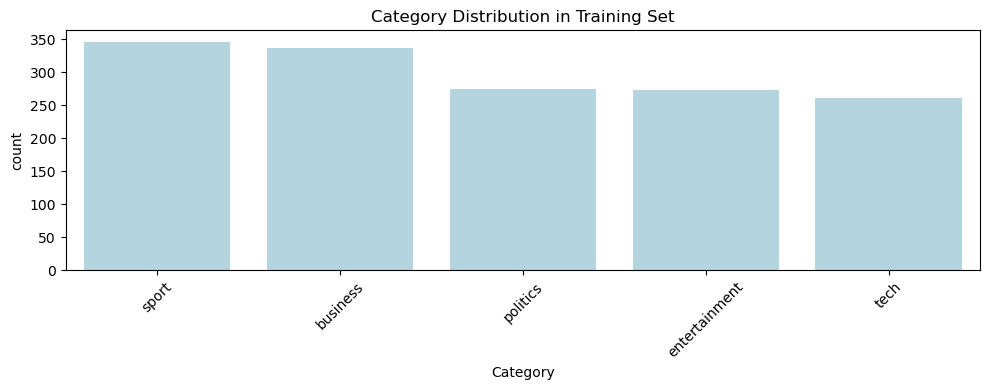

In [30]:
plt.figure(figsize=(10, 4))
sns.countplot(data=bbc_train_df, x="Category", order=bbc_train_df["Category"].value_counts().index, color='lightblue')
plt.title("Category Distribution in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Although in a different order, it's clear that the distribution of news categories in the test dataset matches the pattern seen in the training dataset.

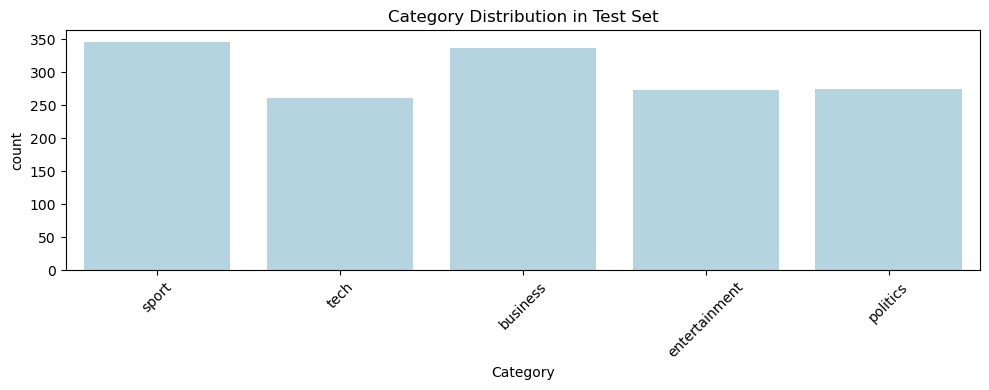

In [31]:
plt.figure(figsize=(10, 4))
sns.countplot(data=bbc_train_df, x="Category", order=bbc_test_solutions_df["Category"].value_counts().index, color='lightblue')
plt.title("Category Distribution in Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Before performing [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization), [stopword removal](https://en.wikipedia.org/wiki/Stop_word#:~:text=Stop%20words%20are%20the%20words,because%20they%20are%20deemed%20insignificant.), and [lemmatization](https://en.wikipedia.org/wiki/Lemmatization) for data cleaning, we'll have a look at the 20 most common words in the uncleaned training dataset `Text` column (notice the high incidence of words with low semantic content).

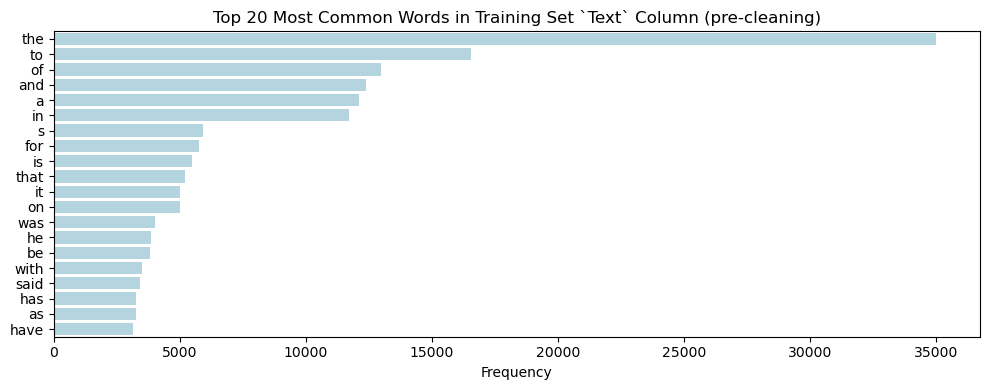

In [32]:
from collections import Counter
all_words_unclean = " ".join(bbc_train_df["Text"]).split()
word_freq_unclean = Counter(all_words_unclean)
most_common_unclean = word_freq_unclean.most_common(20)

plt.figure(figsize=(10, 4))
sns.barplot(x=[w[1] for w in most_common_unclean], y=[w[0] for w in most_common_unclean], color='lightblue')
plt.title("Top 20 Most Common Words in Training Set `Text` Column (pre-cleaning)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

Now we'll define a function to perform data cleaning on the `Text` column in the training and test datasets. We'll use nltk's [WordNetLemmatizer](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnet), [stopwords](https://pythonspot.com/nltk-stop-words/), and [word_tokenize](https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/) methods.

In [33]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(cleaned_tokens)

We'll run the `preprocess_text` function on the `Text` column in each row for both the train and test set.

In [34]:
bbc_train_df["CleanText"] = bbc_train_df["Text"].apply(preprocess_text)
bbc_test_df["CleanText"] = bbc_test_df["Text"].apply(preprocess_text)

After cleaning the `Text` column data, we see a dramatic difference in the 20 most common words in the training dataset.

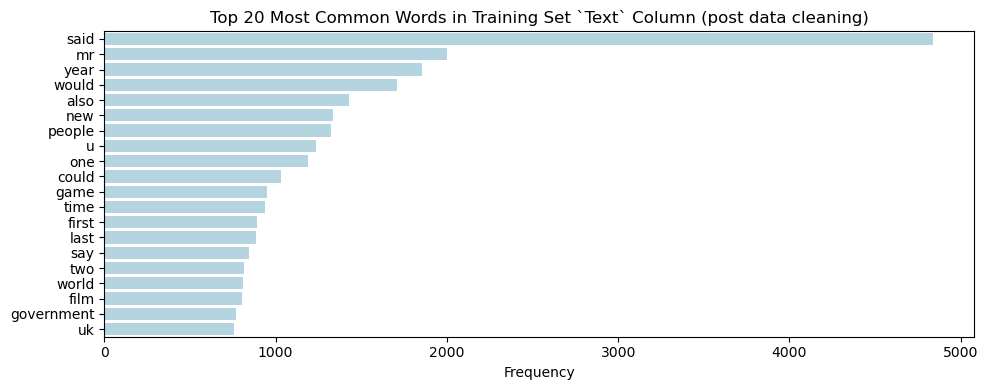

In [35]:
from collections import Counter
all_words = " ".join(bbc_train_df["CleanText"]).split()
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

plt.figure(figsize=(10, 4))
sns.barplot(x=[w[1] for w in most_common], y=[w[0] for w in most_common], color='lightblue')
plt.title("Top 20 Most Common Words in Training Set `Text` Column (post data cleaning)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

Now we'll use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method from scikit-learn to create a data matrix from the `CleanText` columns in our train and test sets in preparation for running non-negative matrix factorization (NMF) to extract topics from the content.

To convert the `CleanText` columns into a numerical form for modeling, we'll use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=In%20information%20retrieval%2C%20tf%E2%80%93idf,appear%20more%20frequently%20in%20general.) (Term Frequency-Inverse Document Frequency) vectorization:

+ TF (term frequency) represents how often a word appears in a document.  
+ IDF (inverse document frequency) is the inverse of the word occurence accross all documents (e.g., if the word "celebrity" occurs in 200 out of 800 articles, then its inverse document frequency would be 800/200 or 4).

Multiplying this combination (TF*IDF) for each word gives higher weight to words that are frequent in a document and relatively rare across all documents. If a word is common accross documents, its inverse document frequency is lower - thus diminishing the weight that the word carries.

Each row (i.e. document) in the TF-IDF matrices directly corresponds to a news article - either in the training set (in `X_train_tfidf`) or the test set (in `X_test_tfidf`). Each column in `X_train_tfidf` or `X_test_tfidf` represents a word in the training set corpus of articles (the training set is used as the base so that the IDF calculation is not influenced by the presence of words in the test set - thus preventing "leakage" from the test set into the training data). The elements in each row are the TF-IDF scores for words in the article corresponding to that row (for each article row, any unused words will have a 0 value).

We will limit the columns in both the train and test TF-IDF matrices to the top 20,000 words. The shape of the resulting TF-IDF matrices is the number of articles by 20000. We will use these matrices for NMF factorization in the next section.

In [36]:
vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = vectorizer.fit_transform(bbc_train_df["CleanText"])
X_test_tfidf = vectorizer.transform(bbc_test_df["CleanText"])

print("TF-IDF Train Matrix Shape:", X_train_tfidf.shape)
print("TF-IDF Test Matrix Shape:", X_test_tfidf.shape)

TF-IDF Train Matrix Shape: (1490, 20000)
TF-IDF Test Matrix Shape: (735, 20000)


We'll use the [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) class from scikit-learn to factor the `X_train_tfidf` matrix into two matrices: W (the basis matrix) and H (the coefficient matrix). We will select the number of latent features (i.e. news article topics) as the hyperparameter in the factorization. Since we happen to know there are five news topic categories in our data, we will begin with 5 for the `n_components` hyperparameter (we can experiment with other values later). The shape of the W matrix will be 1490 by 5, and the shape of the H matrix will be 5 by 20000 (1490 is the number of news articles in the training dataset, 5 the number of latent features (article types), and 20000 the number of columns (i.e. words) included in the `X_train_tfidf` matrix).

In [37]:
n_topics = 5

nmf_model = NMF(n_components=n_topics, random_state=42)
W_train = nmf_model.fit_transform(X_train_tfidf)
H = nmf_model.components_

print("W_train shape (document-topic matrix):", W_train.shape)
print("H shape (topic-word matrix):", H.shape)

W_train shape (document-topic matrix): (1490, 5)
H shape (topic-word matrix): (5, 20000)


The NMF factorization works by assigning latent feature scores for each row in the W matrix. The highest score represents the most likely feature (i.e. topic) for that row (i.e. news article).

We define a numpy array `train_topic_predictions` to extract the index of the column (0 - 4) where NMF has placed the highest latent factor score for each row in the `W_train` matrix.

In [38]:
train_topic_predictions = np.argmax(W_train, axis=1)
train_topic_predictions

array([4, 4, 4, ..., 4, 2, 2], shape=(1490,))

Now we need to see how well these predicted news categories match up with the labeled categories in the training dataset. We'll create a mapping dictionary `topic_to_category` which we will use to convert the latent factor column indices in `train_topic_predictions` to the news article categories in the `Category` column from the training data. We'll assemble the `topic_to_category` mapping by finding the most common labeled category for the documents associated with each predicted column index. Then in `train_category_predictions`, we collect the topic names mapped to the topic indices in the `topic_to_category` dictionary.

In [39]:
topic_to_category = {}

for topic_idx in range(n_topics):
    mask = train_topic_predictions == topic_idx
    true_labels = bbc_train_df["Category"].values[mask]
    if len(true_labels) > 0:
        most_common_category = pd.Series(true_labels).mode()[0]
        topic_to_category[topic_idx] = most_common_category

# Apply mapping to predicted topics for each row in the W matrix
train_category_predictions = [topic_to_category[topic_idx] for topic_idx in train_topic_predictions]

print([topic for topic in topic_to_category.items()])

[(0, 'sport'), (1, 'politics'), (2, 'tech'), (3, 'entertainment'), (4, 'business')]


Let's test the accuracy of the NMF topic predictions for each news article against the training data set labels.

In [14]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(bbc_train_df["Category"], train_category_predictions)
print("Training Accuracy from NMF topics:", train_accuracy)

Training Accuracy from NMF topics: 0.9147651006711409


We see the accuracy for the NMF extraction of news topic categories from the training set is approximately .915, which is fairly high - considering the model is unsupervised!

Now let's look at a confusion matrix for the model's predictions.

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(bbc_train_df["Category"], train_category_predictions)

array([[257,   3,  48,  12,  16],
       [  4, 259,   4,   5,   1],
       [  2,   0, 262,   7,   3],
       [  0,   0,   0, 346,   0],
       [  2,  17,   8,  14, 220]])

The rows in the confusion matrix represent 

sport  
politics  
tech  
entertainment  
business  

We see that the model mistakenly classified 48 sport articles as tech, 12 sport as entertainment, and 16 sport as business. The model also misclassified business articles as politics, tech, and entertainment.

We'll calculate the `W_test` matrix by applying [NMF.transform](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF.transform) on our `X_test-tfidf` matrix. Like `W_train`, each row of `W_test` represents the weights for the five topic categories as associated with the corresponding news article row in `X_test-tfidf`. We'll compile a `test_topic_predictions` list of the most likely topic for each article row in `X_test-tfidf` like we did in `train_topic_predictions`. Then we'll generate `test_category_predictions` from the `topic_to_category` map like we did before for `train_category_predictions`.

In [ ]:
W_test = nmf_model.transform(X_test_tfidf)
test_topic_predictions = np.argmax(W_test, axis=1)
test_category_predictions = [topic_to_category[topic_idx] for topic_idx in test_topic_predictions]

[(0, 'sport'), (1, 'politics'), (2, 'tech'), (3, 'entertainment'), (4, 'business')]


To test the accuracy of the NMF model's news article category predictions for the test data set, we'll export a .csv and upload it to https://www.kaggle.com/competitions/learn-ai-bbc/submissions to obtain the results.

In [16]:
nmf_submission = bbc_test_df[["ArticleId"]].copy()
nmf_submission["Category"] = test_category_predictions
nmf_submission.to_csv("bbc_nmf_submission.csv", index=False)

After uploading to Kaggle, the accuracy score I got for the NMF model's `test_category_predictions` was 0.69795. This is not as good as the model's predictions against the training set labels, but still impressive that the unsupervised model produces accuracy this high on unseen test data (with no labelled data in the training).

Now we'll see how changing the `n_components` hyperparameter in calculating the W and H matrices for the train data set affects accuracy for the predicitons (`n_components` represents the number of news topic categories) . We'll cycle through 3 - 10 and view the results.

In [17]:
topic_counts = [3, 4, 5, 6, 7, 8, 9, 10]
train_scores = []
test_scores = []

for n in topic_counts:
    model = NMF(n_components=n, random_state=42)
    W_train = model.fit_transform(X_train_tfidf)
    H = model.components_
    train_topic_predictions = np.argmax(W_train, axis=1)

    topic_to_category = {}
    for topic_idx in range(n):
        mask = train_topic_predictions == topic_idx
        true_labels = bbc_train_df["Category"].values[mask]
        if len(true_labels) > 0:
            topic_to_category[topic_idx] = pd.Series(true_labels).mode()[0]

    train_category_predictions = [topic_to_category[topic_idx] for topic_idx in train_topic_predictions]
    train_acc = accuracy_score(bbc_train_df["Category"], train_category_predictions)

    train_scores.append(train_acc)

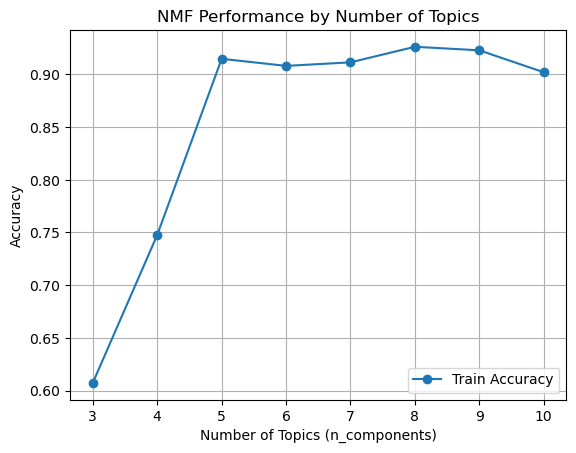

In [18]:
plt.plot(topic_counts, train_scores, marker='o', label='Train Accuracy')
plt.xlabel("Number of Topics (n_components)")
plt.ylabel("Accuracy")
plt.title("NMF Performance by Number of Topics")
plt.legend()
plt.grid(True)
plt.show()


We can clearly see the elbow at 5, which is to be expected as the true number of topic categories is 5.

Next, we'll train a supervised logistic regression model on the labelled training data for news article categories and test the model's predictions.

In [19]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, bbc_train_df["Category"])

lr_train_predictions = lr_model.predict(X_train_tfidf)
lr_test_predictions = lr_model.predict(X_test_tfidf)

lr_train_accuracy = accuracy_score(bbc_train_df["Category"], lr_train_predictions)

print("Supervised Learning Train Accuracy:", lr_train_accuracy)


Supervised Learning Train Accuracy: 0.9966442953020134


The logistic regression model has very high accuracy predicting the topic categories in the training set.

Now let's test the logistic regression model's predictions against the test data set. We'll upload to Kaggle again to obtain the results.

In [20]:
lr_submission = bbc_test_df[["ArticleId"]].copy()
lr_submission["Category"] = lr_test_predictions # assuming this holds the LR predictions
lr_submission.to_csv("bbc_lr_submission.csv", index=False)

I got .98095 accuracy for the logistic regression model's predictions against the test set. This demonstrates how, given the choice between supervised and unsupervised methods, supervised learning would generally be the preferred method whenever we have access to labeled data.

# References

1. BBC News Classification Kaggle Competition – [https://www.kaggle.com/competitions/learn-ai-bbc/overview](https://www.kaggle.com/competitions/learn-ai-bbc/overview)
2. Non-negative Matrix Factorization (NMF) – [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
3. nltk: Natural Language Toolkit – [https://www.nltk.org/](https://www.nltk.org/)
4. TF-IDF – [https://en.wikipedia.org/wiki/Tf%E2%80%93idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
5. Word Tokenization – [https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)
6. Stop Words – [https://en.wikipedia.org/wiki/Stop_word](https://en.wikipedia.org/wiki/Stop_word)
7. Lemmatization – [https://en.wikipedia.org/wiki/Lemmatization](https://en.wikipedia.org/wiki/Lemmatization)